# Linear Splines

In [1]:
import itertools
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from utils import *

plt.rcParams.update({'font.size': 12})

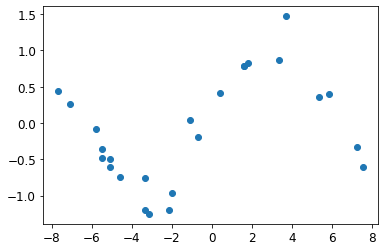

In [2]:
np.random.seed(42)
x = 8.0 * (2.0 * np.random.rand(25) - 1.0)
y = np.sin(0.5 * x) + 0.2 * np.random.randn(len(x))
plt.plot(x, y, 'o')
plt.show()

In [3]:
qs = np.quantile(x, q=[0.25, 0.5, 0.75])
qs

array([-5.06552784, -2.0073581 ,  1.78964632])

In [4]:
def pymc3_linear_spline_model(x, y, knots):
    # Build a PyMC3 linear spline model
    with pm.Model() as model:
        # Intercept and slope priors
        alpha = pm.Normal('alpha', mu=0.0, sd=8.0)
        gamma = pm.Normal('gamma', mu=0.0, sd=8.0)
        
        if not isinstance(knots, int):
            beta = pm.Normal('beta', mu=0.0, sd=8.0, shape=len(knots))
            mu = pm.Deterministic('mu', alpha + gamma * x + tt.dot(tt.nnet.relu(np.expand_dims(x, axis=1) - knots), beta))
        else:
            beta = pm.Normal('beta', mu=0.0, sd=8.0, shape=knots)
            tau = pm.Dirichlet('tau', [1.0] * (knots + 1))
            xi = pm.Deterministic('xi', x.min() + (x.max() - x.min()) * tt.cumsum(tau[:-1]))
            mu = pm.Deterministic('mu', alpha + gamma * x + tt.dot(tt.nnet.relu(np.expand_dims(x, axis=1) - xi), beta))

        # Noise prior
        eps = pm.HalfCauchy('eps', 1.0)
        # Likelihood
        y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
        return model

In [5]:
# Sample from the posterior
model = pymc3_linear_spline_model(x, y, knots=qs)
with model:
    trace = pm.sample(
        draws=30_000, tune=30_000, target_accept=0.95,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, gamma, alpha]


Sampling 3 chains for 30_000 tune and 30_000 draw iterations (90_000 + 90_000 draws total) took 548 seconds.


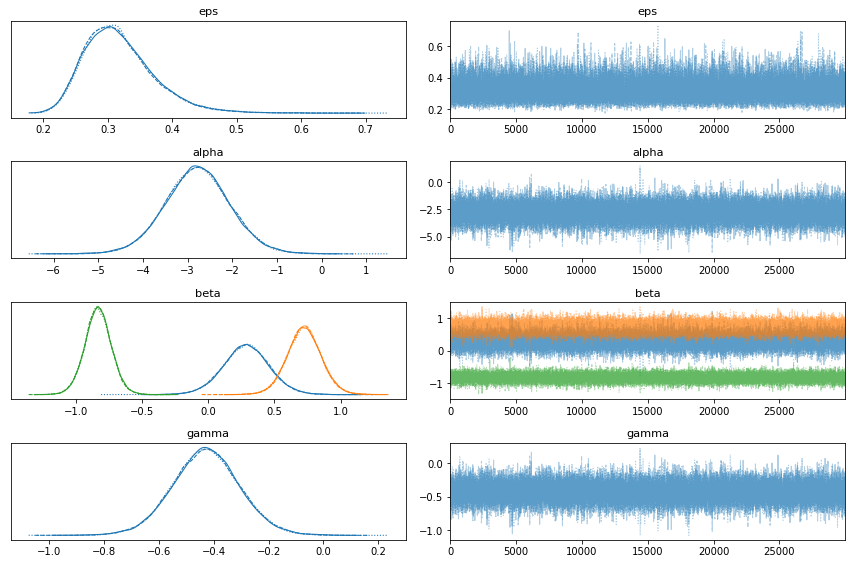

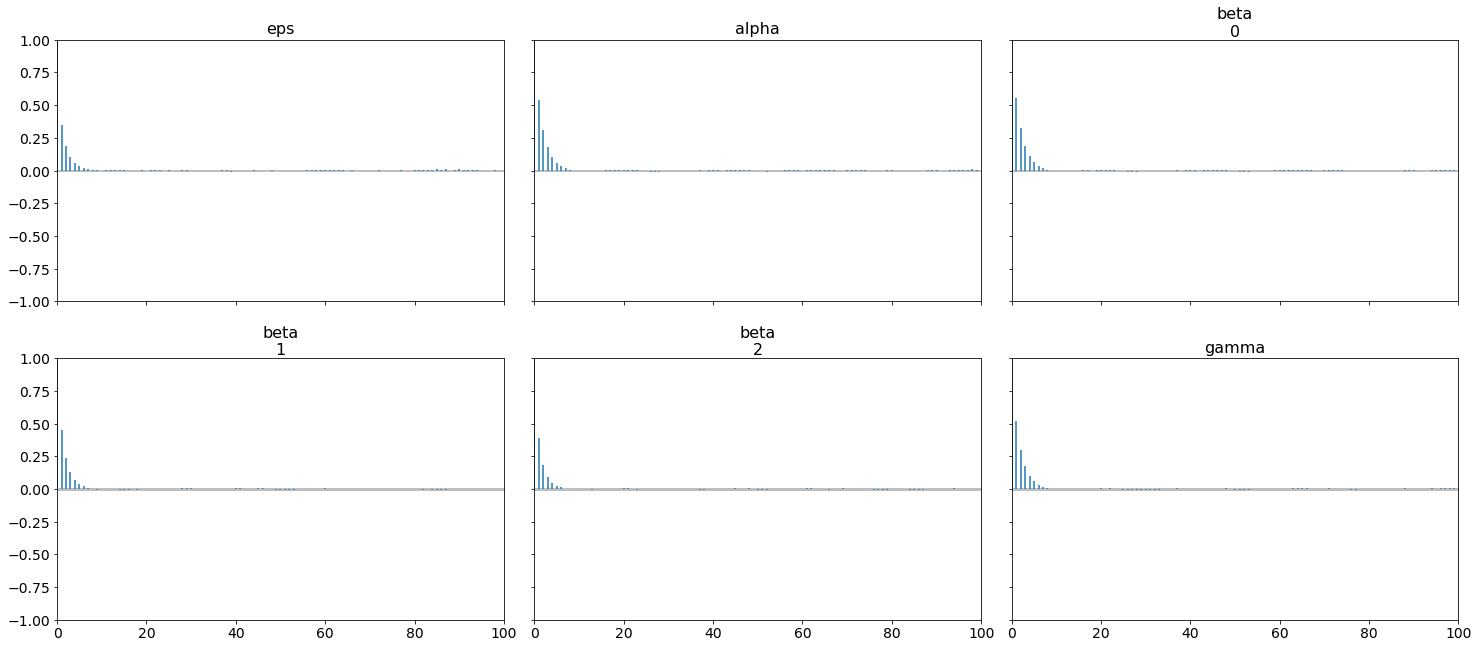

In [6]:
# Plot traces and auto-correlation plots
plot_trace(trace, variables=['eps', 'alpha', 'beta', 'gamma'], autocorr_combined=True)

In [7]:
test_x = np.linspace(-8.0, 8.0, 100)
test_y = np.sin(0.5 * test_x)
test_model = pymc3_linear_spline_model(test_x, test_y, knots=qs)

with test_model:
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['y_pred'], keep_size=True)
    pred_samples = pred_samples['y_pred']
med_samples = np.median(pred_samples.reshape(-1, pred_samples.shape[2]), axis=0)

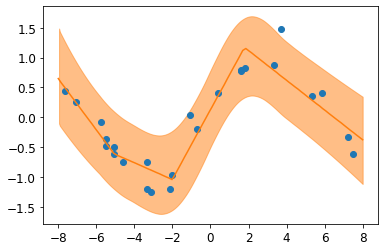

In [8]:
az.plot_hdi(test_x, pred_samples)
plt.plot(x, y, 'o')
plt.plot(test_x, med_samples)
plt.show()

## Linear Spline with Knots Priors

It is also possible to define a prior over knots, at the cost of a way higher computational complexity when sampling from the posterior.
That is, we can define a prior over $K$ knots in the range $(0, 1)$ in order to ensure that $\xi_i < \xi_j$ if and only if $i<j$.
To do so, we first impose a Dirichlet prior distribution on additional variables $\tau_1,\tau_2,\ldots,\tau_{K+1}$ as follows.

$$\tau \sim \mathrm{Dirichlet}(\alpha_1,\alpha_2,\ldots,\alpha_{K+1}) \qquad \alpha_i > 0 \quad 1\leq i\leq K+1$$

The Dirichlet distribution has two important properties.

$$\tau_i \in (0,1) \quad 1\leq i\leq K+1 \qquad \sum_{i=1}^{K+1}\tau_i=1$$

$$\mathbb{E}[\tau_i] = \frac{\alpha_i}{\sum_{i=1}^{K+1}\alpha_i}$$

We can then define a prior distribution on knots as follows.

$$\xi_0=0 \qquad \xi_i \sim \xi_{i-1} + \tau_i \qquad 1\leq i\leq K$$

Now consider the case of $\alpha_i=1\quad 1\leq i\leq K+1$.
The choice of this prior on knots $\xi_1,\xi_2,\ldots,\xi_K$ is interesting because the _expected knots_ are distributed _uniformly_ in the interval $(0, 1)$.

$$\xi_i\in (0,1) \qquad \mathbb{E}[\xi_i] = i\frac{1}{K+1} \qquad 1\leq i\leq K$$

In [9]:
# Sample from the posterior
model = pymc3_linear_spline_model(x, y, knots=2)
with model:
    trace = pm.sample(
        draws=30_000, tune=30_000, target_accept=0.95,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, tau, beta, gamma, alpha]


Sampling 3 chains for 30_000 tune and 30_000 draw iterations (90_000 + 90_000 draws total) took 636 seconds.
The number of effective samples is smaller than 25% for some parameters.


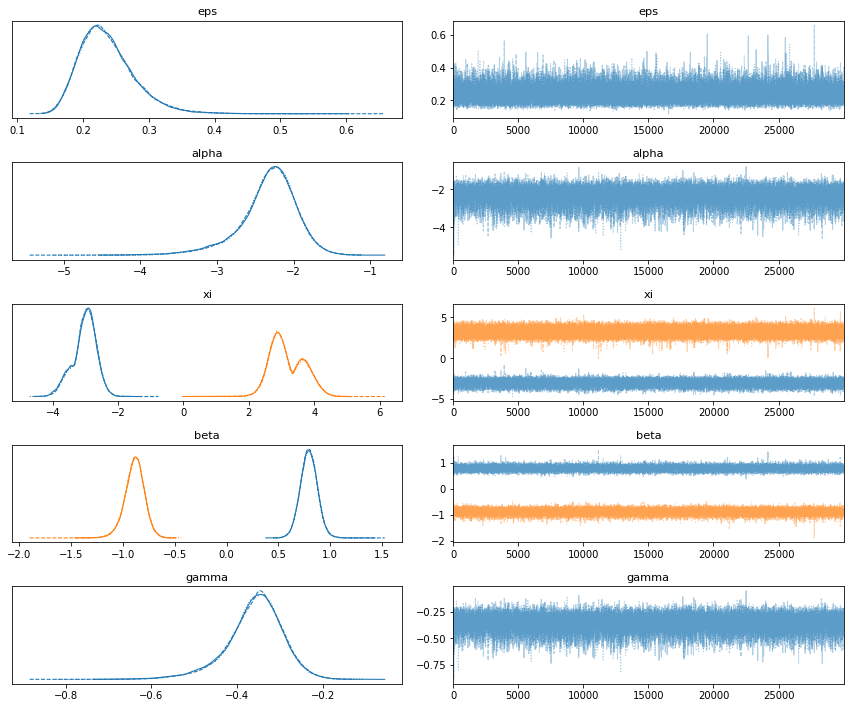

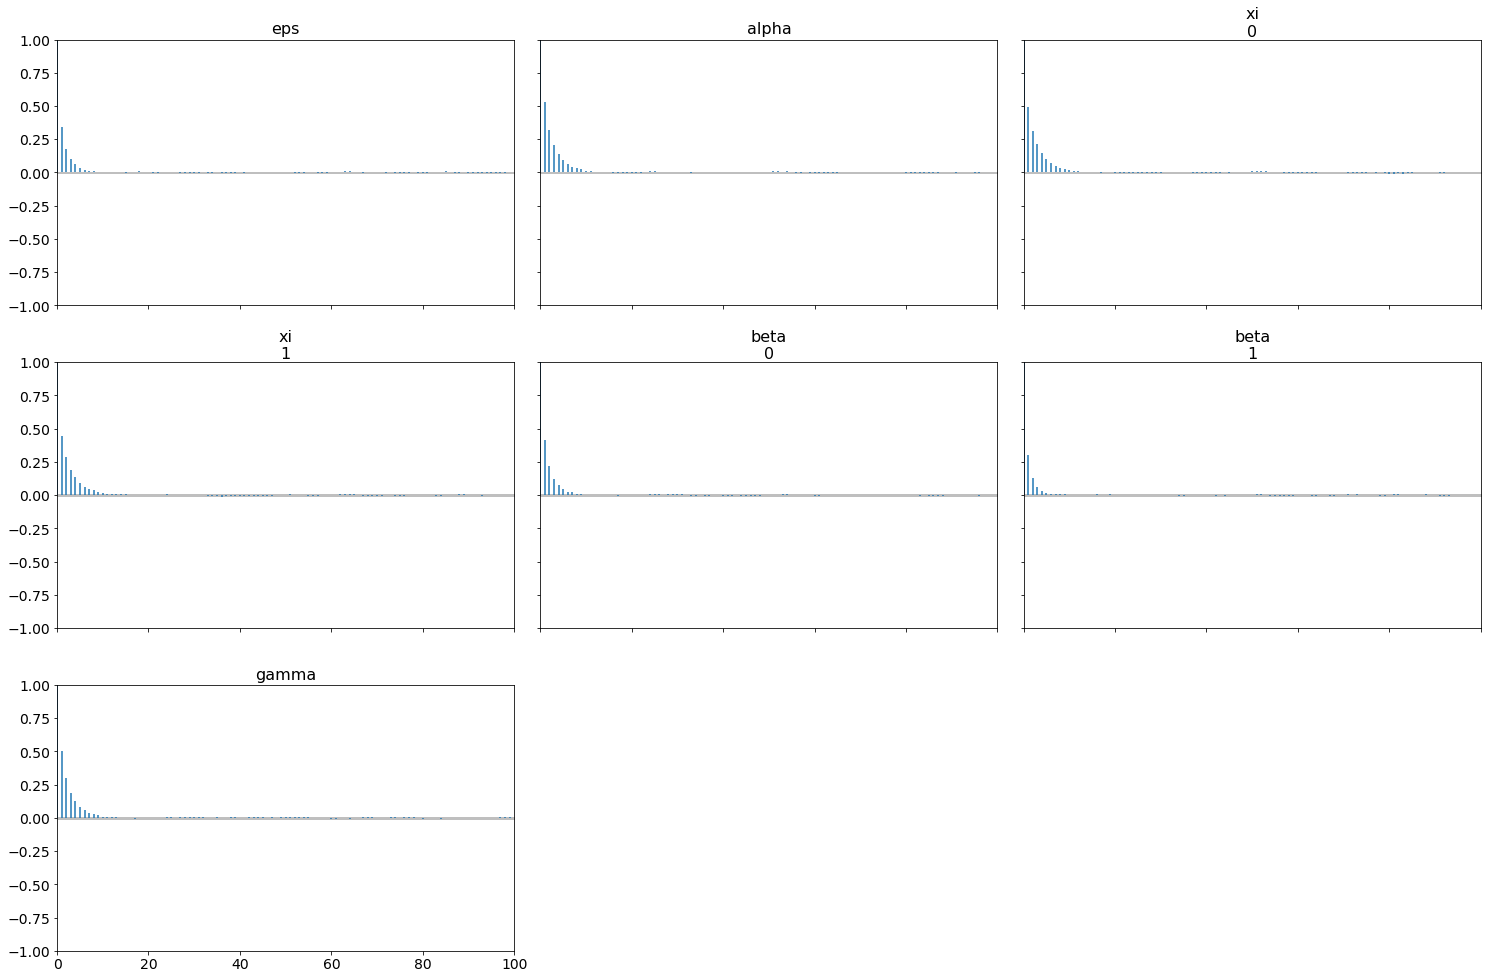

In [10]:
# Plot traces and auto-correlation plots
plot_trace(trace, variables=['eps', 'alpha', 'xi', 'beta', 'gamma'], autocorr_combined=True)

In [11]:
test_x = np.linspace(-8.0, 8.0, 100)
test_y = np.sin(0.5 * test_x)
test_model = pymc3_linear_spline_model(test_x, test_y, knots=2)

with test_model:
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['y_pred'], keep_size=True)
    pred_samples = pred_samples['y_pred']
med_samples = np.median(pred_samples.reshape(-1, pred_samples.shape[2]), axis=0)

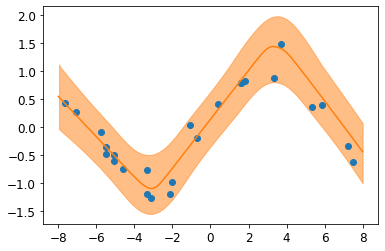

In [12]:
az.plot_hdi(test_x, pred_samples)
plt.plot(x, y, 'o')
plt.plot(test_x, med_samples)
plt.show()